# Sherpa and the Terrible, Horrible, No Good, Very Bad Optimizer

Sherpa comes with a set of statistics and optimisers, but it is possible to write your own. For an optimiser, we need to be able to
write a function that matches the following signature (note that this is not the actual signature, since we allow the arrays to be sent in as sequences, for instance):

    fcn: Callable[[np.ndarray], tuple[float, np.ndarray]]
    x0: np.ndarray
    xmin: np.ndarray
    xmax: np.ndarray

The `fcn` argument represents the "statistic" value - given an array of values it returns the statistic value and a "per-data-bin" statistic value. We don't need to worry about how it is created: the `sherpa.fit.Fit` class constructs the routine given the data and model and we just
need to call it. The `x0`, `xmin`, and `xmax` arguments give the initial starting values and their limits (that is, these three arrays are 1D and have the same size). You can provide extra arguments - if your optimiser has optional or tweakable behaviour - as keyword arguments.

The retturn value is the tuple

    (bool, np.ndarray, float, str, dict[str, Any])

where the first value indicates that the optimization converted (or succeeded), the second is the best-fit values, the third
is the best-fit statistic, the fourth a string that may be sent to the user, and the fifth is a dictionary that can be used
to send back interesting information.

One thing to note is that the optimizer does not care about the `Data` or `Model` classes; this is "hidden away" in the `fcn` parameter, and all it cares about is the list of parameter values (here `x0`) along with their limits (`xmin` and `xmax`). This lets you use these optimizing functions (or classes) for other cases, such as [function optimization](https://sherpa.readthedocs.io/en/4.16.1/extra/optimize_function.html).

## How bad an optimizer can you think of?

For this example, I've decided to try an optimizer which, for each iteration

- takes the parameter values and adds {-1, 0, 1} to each of them
- calculates the statistic
- if there's no fit (i.e. lower statistic) then exit
- otherwise start from the new best-fit location

This really is only useful as an example!

Let's start by importing a few useful symbols from Sherpa and NumPy, and ceck what version of Sherpa we are using (as hopefully some things here wil be improved):

In [1]:
from typing import Any, Callable

import numpy as np

from sherpa.optmethods.optfcts import FUNC_MAX

# These (or something like then) will hopefully be added to `optfcts` but for 4.16.1
# we define them here. Technically Sherpa can accept Sequence[float] but let's just
# think about ndarrays.
#
OptReturn = tuple[bool,            # did the optimiser succeed
                  np.ndarray,      # best-values
                  float,           # final statistic value
                  str,             # message
                  dict[str, Any]]  # information to pass back

# The routine sent to the optimizer is sent the current valus and returns
# the statistic value (the thing we want to minimize) and an array of
# per-bin statistic values (which we are going to ignore).
#
StatCallback = Callable[[np.ndarray], tuple[float, np.ndarray]]


def _outside_limits(x: np.ndarray,
                    xmin: np.ndarray,
                    xmax: np.ndarray
                    ) -> bool:
    """Are any x values outside the xmin/max range?"""
    return bool(np.any(x < xmin) or np.any(x > xmax))


class InfinitePotential:
    """Ensure the parameter values stay within bounds.

    The idea is that if sent a value outside the parameter limits we
    return "infinity" (here defined to be the maximum value we'd
    expect rather than inf, to avoid causing problems to the
    optimizer).

    """

    __slots__ = ("func", "minval", "maxval")

    def __init__(self,
                 func: StatCallback,
                 minval: np.ndarray,
                 maxval: np.ndarray) -> None:
        self.func = func
        self.minval = minval
        self.maxval = maxval

    def __call__(self, pars: np.ndarray) -> float:
        if np.isnan(pars).any() or _outside_limits(pars,
                                                   self.minval,
                                                   self.maxval):
            return FUNC_MAX

        return self.func(pars)[0]

In [2]:
import sherpa
sherpa.__version__

'4.18.0.rc1'

We start with the permutation routine: given a set of parameter values, return a list of parameter values where we have
permuted each parameter by {-1, 0, 1}.

In [3]:
import itertools

def permute_x(x: np.ndarray) -> list[np.ndarray]:
    """Return -1,0,+1 for each parameter.

    We should really drop the all-0 version, as we already
    know the value for this case.

    """

    out = []
    args = [[-1, 0, 1] for _ in x]
    for shifts in itertools.product(*args):
        out.append(x + np.asarray(shifts))

    return out

We can check what happens if we were to give it `[10, 50, 3]`:

In [4]:
permute_x([10, 50, 3])

[array([ 9, 49,  2]),
 array([ 9, 49,  3]),
 array([ 9, 49,  4]),
 array([ 9, 50,  2]),
 array([ 9, 50,  3]),
 array([ 9, 50,  4]),
 array([ 9, 51,  2]),
 array([ 9, 51,  3]),
 array([ 9, 51,  4]),
 array([10, 49,  2]),
 array([10, 49,  3]),
 array([10, 49,  4]),
 array([10, 50,  2]),
 array([10, 50,  3]),
 array([10, 50,  4]),
 array([10, 51,  2]),
 array([10, 51,  3]),
 array([10, 51,  4]),
 array([11, 49,  2]),
 array([11, 49,  3]),
 array([11, 49,  4]),
 array([11, 50,  2]),
 array([11, 50,  3]),
 array([11, 50,  4]),
 array([11, 51,  2]),
 array([11, 51,  3]),
 array([11, 51,  4])]

As mentioned, this is really not a good strategy, but let's run with it.

The implementation is pretty simple:

- use the `InfinitePotential` class to handle the fact that we want the optimizer to obey the bounds a user has added for the parameters without having to worry about this in the code; in this case the `cb` function we create will just return "positive infinity" if any parameter value exceeds the parameter limits (actually, it returns the maximum float64 value, but we can pretend it's infinite)
- check that our starting positional is actually valid, and find the initial statistic value
- loop until we hit our maximum number of iterations (this is an optimization-specific feature which is indicated by the fact it's a named keyword)
  - use `permute_x` to create the proposed new positions
  - for each of these new positions calculate the statistic value
    - if this statistic value is lower than any we've seen, we store the parameters
  - if there has been no improvement we can exit
  - otherwise we replace the best-fit parameters with the stored values and repeat the loop
- at this point we have either found our best-fit location, in which case we can send back `True`
- otherwise we send back `False`

In [5]:
def opty(fcn: StatCallback,
         x0: np.ndarray,
         xmin: np.ndarray,
         xmax: np.ndarray,
         maxiter: int = 10,
         verbose: bool = False
         ) -> OptReturn:
    """Find the best location within +/-1.

    This is not a real optimizer and is intended for educational
    purposes only. Given x0, calculate all combinations of parameters
    which are +/-1 from it and return the "best fit". This always
    picks the "best fit" and uses that as the next iteration, choosing
    the first such value if there is a tie. The maxiter argument is
    used to bound the number of iterations.

    """

    # Ensure that we remain bounded within xmin, xmax since this
    # optimizer is not going to do so itself.
    #
    cb = InfinitePotential(fcn, xmin, xmax)

    # What is our starting point?
    #
    # Note: the float conversion here is only to please mypy and is
    # something to be improved in the typing rules.
    #
    cstat = float(cb(x0))
    if cstat == FUNC_MAX:
        if verbose:
            print("Oops")

        return (False, x0, cstat, "Invalid parameters", {})

    ctr = 0
    x = np.copy(x0)
    success = False
    nfev = 0  # track the number of evaluations
    store = []
    while ctr < maxiter:

        # permute values
        xbest = None
        for xnew in permute_x(x):
            nstat = float(cb(xnew))
            nfev += 1

            # do we have a better fit?
            if nstat < cstat:
                if verbose:
                    print(f"- {cstat} -> {nstat} at {xnew}")

                xbest = xnew
                cstat = nstat
                store.append(xnew)

        # If we have not found a better fit then exit.
        #
        if xbest is None:
            success = True
            break

        ctr += 1
        x = xbest

    msg = "Success" if success else "Hit iteration limit"
    return (success, x, cstat, msg, {"nfev": nfev, "best-fit": x, "best-stat": cstat, "store": store})

We can use this to make a Sherpa optimization class (the `OptMethod` class will identify the keyword arguments to `opty` and make fields for them, as we'll see below when we change the `verbose` setting):

In [6]:
from sherpa.optmethods import OptMethod

class Opty(OptMethod):
    """A Not-An-Optimizer optimizer.

    You do not need to name the class the same as the optimization
    function, but naming is hard.

    """

    def __init__(self, name="opty"):
        super().__init__(name=name, optfunc=opty)

## How can we test this?

We could just create `Data` and `Model` instances and pass them, along with a `Opty` instance, to `sherpa.fit.Fit`. However, that's a lot of effort when we can use the UI layer to do much of this for us (although, if you do want to know how, see the end of this notebook, in the "I really want to do this with objects" section).

The only issue is that, as of Sherpa 4.16.1, there's no-way to "register" a new optimizer with the code, so you have to send in an optimization object directly.

In [7]:
from sherpa import ui

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


For this example I am going to create a fake data set that we can fit a `Box1D` model to to calculate the best
starting and ending point:

In [8]:
ui.load_arrays(1,
               [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
               [0, 0, 5, 3, 4, 6, 5, 4, 3, 5, 7, 0, 8, 3, 0])

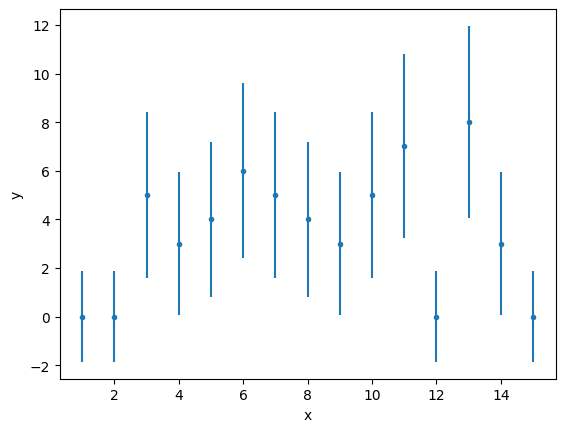

In [9]:
ui.plot_data()

In [10]:
# Let's just hide the error bars here
ui.get_plot_prefs("data")["yerrorbars"] = False
ui.get_plot_prefs("resid")["yerrorbars"] = False

We create the model expression, where we

- freeze the amplitude (as I didn't want to worry about fitting that)
- start the box at the range `x=7-8`

In [11]:
mdl = ui.create_model_component("box1d", "mdl")

mdl.ampl = 5
mdl.ampl.freeze()

mdl.xlow = 7
mdl.xhi = 8

In [12]:
ui.set_source(1, mdl)
ui.set_stat("leastsq")

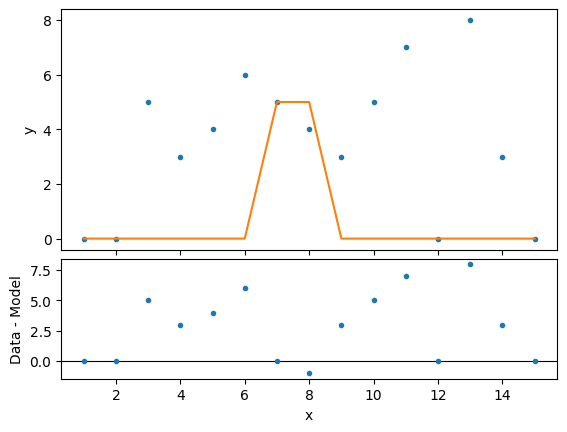

In [13]:
ui.plot_fit_resid()

We then create the optimization object and change one of its parameters (the verbose setting), so that we expect to see some extra output during the fit (the Sherpa `OptMethod` class has logic to take the keyword arguments for the optimization function - in this case `opty` - and turn them into fields of the class:

In [14]:
opt = Opty()
opt.verbose = True

In [15]:
print(opt)

name    = opty
maxiter = 10
verbose = True


We can then tell Sherpa to use this optimizer:

In [16]:
ui.set_method(opt)

With this set we can see the options (i.e. the named parameters of `opty`):

In [17]:
ui.get_method_opt()

{'maxiter': 10, 'verbose': True}

Let's check the model first:

In [18]:
print(mdl)

box1d.mdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mdl.xlow     thawed            7 -3.40282e+38  3.40282e+38           
   mdl.xhi      thawed            8 -3.40282e+38  3.40282e+38           
   mdl.ampl     frozen            5 -3.40282e+38  3.40282e+38           


With this we can try to fit the data. The first lines (beginning ` - `) are from `opty` because `verbose` set. They indicate when we found new best-fit solutions (so we can see the low edge decrease and the high edge increase over time): 

In [19]:
ui.fit()

- 243.0 -> 223.0 at [6. 7.]
- 223.0 -> 208.0 at [6. 8.]
- 208.0 -> 203.0 at [6. 9.]
- 203.0 -> 193.0 at [5. 8.]
- 193.0 -> 188.0 at [5. 9.]
- 188.0 -> 163.0 at [ 5. 10.]
- 163.0 -> 158.0 at [ 4. 10.]
- 158.0 -> 113.0 at [ 4. 11.]
- 113.0 -> 88.0 at [ 3. 11.]
Dataset               = 1
Method                = opty
Statistic             = leastsq
Initial fit statistic = 243
Final fit statistic   = 88 at function evaluation 45
Data points           = 15
Degrees of freedom    = 13
Change in statistic   = 155
   mdl.xlow       3           
   mdl.xhi        11          


In [20]:
print(mdl)

box1d.mdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mdl.xlow     thawed            3 -3.40282e+38  3.40282e+38           
   mdl.xhi      thawed           11 -3.40282e+38  3.40282e+38           
   mdl.ampl     frozen            5 -3.40282e+38  3.40282e+38           


We can display the new "best fit":

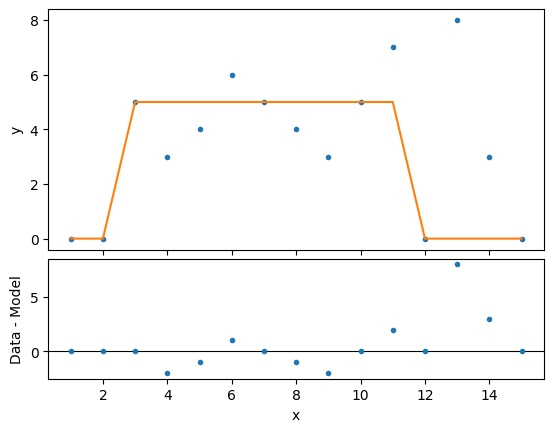

In [21]:
ui.plot_fit_resid()

So, we can see that it's expanded the box to `x=3 - 11`. I had explicitly set `x=12` to have no counts so that the fit was going to stop there, rather than try to expand to include `x=13 - 14`. And it did, so hurray me!

We can get at the "extra" information provided by `opty` via the `extra_output` field of the fit results:

In [22]:
ui.get_fit_results().extra_output

{'nfev': 45,
 'best-fit': array([ 3., 11.]),
 'best-stat': 88.0,
 'store': [array([6., 7.]),
  array([6., 8.]),
  array([6., 9.]),
  array([5., 8.]),
  array([5., 9.]),
  array([ 5., 10.]),
  array([ 4., 10.]),
  array([ 4., 11.]),
  array([ 3., 11.])]}

One potential gotchya is that the fit results have used the `nfev` value we created in the dictionary. It is not required, but the screen output of the fit would be *slightly* different it it wasn't present (it would drop the "at function evaluation xxx" suffix when reporting the final fit statistic), and would not set the `nfev` field in the fit results:

In [23]:
ui.get_fit_results().nfev

45

## Tracking the fit positions

We could store the parameter values tried out in the optimization method and return them in the dict, so they could be accessed from the `extra_output` field. The `fit` method already has two ways to access this data, as it can write the parameter values it tries to a file during the fit, or record them.

### New in 4.17.1

THe `4.17.1` release added the `record_steps` option to the `fit` call. There is also the ability to write the parameters out to a file (which is how this notebook used to access the data).

In [24]:
mdl.reset()
print(mdl)

box1d.mdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mdl.xlow     thawed            7 -3.40282e+38  3.40282e+38           
   mdl.xhi      thawed            8 -3.40282e+38  3.40282e+38           
   mdl.ampl     frozen            5 -3.40282e+38  3.40282e+38           


In [25]:
ui.fit(record_steps=True)

- 243.0 -> 223.0 at [6. 7.]
- 223.0 -> 208.0 at [6. 8.]
- 208.0 -> 203.0 at [6. 9.]
- 203.0 -> 193.0 at [5. 8.]
- 193.0 -> 188.0 at [5. 9.]
- 188.0 -> 163.0 at [ 5. 10.]
- 163.0 -> 158.0 at [ 4. 10.]
- 158.0 -> 113.0 at [ 4. 11.]
- 113.0 -> 88.0 at [ 3. 11.]
Dataset               = 1
Method                = opty
Statistic             = leastsq
Initial fit statistic = 243
Final fit statistic   = 88 at function evaluation 45
Data points           = 15
Degrees of freedom    = 13
Change in statistic   = 155
   mdl.xlow       3           
   mdl.xhi        11          


The data is accessible from `get_fit_results`:

In [26]:
fres = ui.get_fit_results()
stats = fres.record_steps

In [27]:
stats

array([( 0, 243., 7.,  8.), ( 1, 223., 6.,  7.), ( 2, 208., 6.,  8.),
       ( 3, 203., 6.,  9.), ( 4, 258., 7.,  7.), ( 5, 243., 7.,  8.),
       ( 6, 238., 7.,  9.), ( 7, 283., 8.,  7.), ( 8, 268., 8.,  8.),
       ( 9, 263., 8.,  9.), (10, 193., 5.,  8.), (11, 188., 5.,  9.),
       (12, 163., 5., 10.), (13, 208., 6.,  8.), (14, 203., 6.,  9.),
       (15, 178., 6., 10.), (16, 243., 7.,  8.), (17, 238., 7.,  9.),
       (18, 213., 7., 10.), (19, 183., 4.,  9.), (20, 158., 4., 10.),
       (21, 113., 4., 11.), (22, 188., 5.,  9.), (23, 163., 5., 10.),
       (24, 118., 5., 11.), (25, 203., 6.,  9.), (26, 178., 6., 10.),
       (27, 133., 6., 11.), (28, 133., 3., 10.), (29,  88., 3., 11.),
       (30, 113., 3., 12.), (31, 158., 4., 10.), (32, 113., 4., 11.),
       (33, 138., 4., 12.), (34, 163., 5., 10.), (35, 118., 5., 11.),
       (36, 143., 5., 12.), (37, 158., 2., 10.), (38, 113., 2., 11.),
       (39, 138., 2., 12.), (40, 133., 3., 10.), (41,  88., 3., 11.),
       (42, 113., 3.

We can lool at how the statistic changes with the evauation number. Thanks to the way the "optimizer" works we do not see a monotonic
decrease:

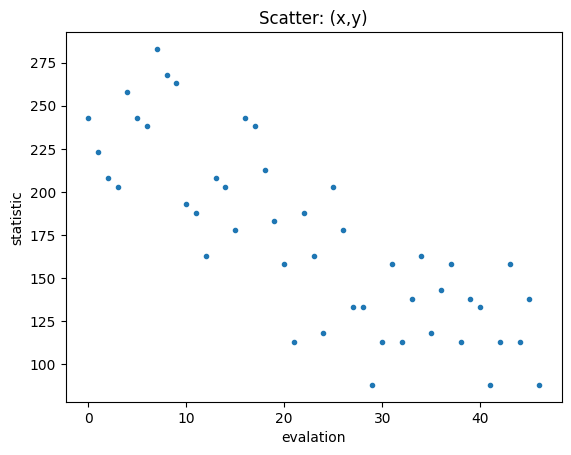

In [28]:
ui.plot_scatter(stats["nfev"], stats["statistic"], xlabel="evalation", ylabel="statistic")

We can also look at the search surface and the path we take (this uses the screen output from setting the `verbose` parameter, which is accessed via the `store` element for this plot, almost like I went "oh, that would make my life easier to have available"):

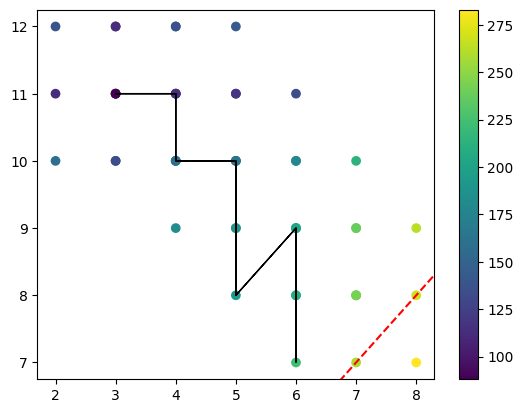

In [29]:
from matplotlib import pyplot as plt

plt.scatter(stats["mdl.xlow"], stats["mdl.xhi"], c=stats["statistic"])
plt.colorbar()

# Take the "best-fit" locations from the fit output and draw lines connecting them.
store = ui.get_fit_results().extra_output["store"]
pxlo = None
pxhi = None
for xlo, xhi in store:
    if pxlo is not None:
        plt.arrow(pxlo, pxhi, xlo - pxlo, xhi - pxhi)

    pxlo, pxhi = xlo, xhi

# Let's show the xlow=xhi line, for reasons.
ax = plt.gca()
ax.set_xlim(auto=False)
ax.set_ylim(auto=False)
plt.plot([6, 9], [6, 9], '--', c='r');

Note that we actually have some cases where `xlo > xhi`, which is not really valid (anything on the dotted line, or to it's lower-right, is technically invalid and the model ends up just returning 0's for all bins). We can try to avoid this by setting the `xlow` parameter to have a maximum value and the `xhi` a minimum value to avoid this:

In [30]:
mdl.reset()

mdl.xlow.max = 7
mdl.xhi.min = 8

print(mdl)

box1d.mdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mdl.xlow     thawed            7 -3.40282e+38            7           
   mdl.xhi      thawed            8            8  3.40282e+38           
   mdl.ampl     frozen            5 -3.40282e+38  3.40282e+38           


In [31]:
ui.set_method_opt("verbose", False)

ui.fit(record_steps=True, clobber=True)

Dataset               = 1
Method                = opty
Statistic             = leastsq
Initial fit statistic = 243
Final fit statistic   = 88 at function evaluation 45
Data points           = 15
Degrees of freedom    = 13
Change in statistic   = 155
   mdl.xlow       3           
   mdl.xhi        11          


So, the end result is the same, but things are slightly different:

- the number of function evaluations may be different (in this case it isn't, but with some code changes I've made but not yet turned into a PR it actually does, and now I'm interested why, but that's for another notebook)
- the set of points searched is slightly different (which you can't see from above, but we can looking at the output file)

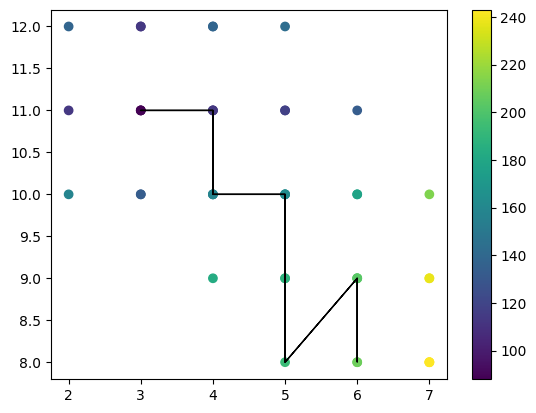

In [32]:
stats2 = ui.get_fit_results().record_steps

plt.scatter(stats2["mdl.xlow"], stats2["mdl.xhi"], c=stats2["statistic"])
plt.colorbar()

store = ui.get_fit_results().extra_output["store"]
pxlo = None
pxhi = None
for xlo, xhi in store:
    if pxlo is not None:
        plt.arrow(pxlo, pxhi, xlo - pxlo, xhi - pxhi)

    pxlo, pxhi = xlo, xhi

# There's no points where xlow >= xhi, so don't bother with adding a line

The statistic points also show a slight difference in behaviour. What is most interesting - but only if you are interested in the weeds of the optimization code, which you might just be if you're reading this - is that the number of function evaluations seems to stop at 41, even though we were told there were 45.

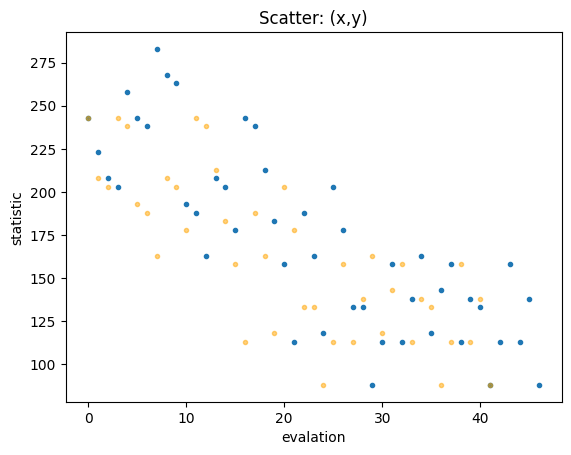

In [33]:
ui.plot_scatter(stats["nfev"], stats["statistic"], xlabel="evalation", ylabel="statistic")
ui.plot_scatter(stats2["nfev"], stats2["statistic"], overplot=True, alpha=0.5, color="orange")

Just to check (the first row is labelled 0 as it is likely to represent the input values, as it is in the case of `opty`:

In [34]:
len(stats2)

42

## Actually, come to think of it, just how is this output file created?

If we look at `opty`, there's no obvious way for this data to be stored (i.e. `opty` has no knowledge of it). This is because the fit code sets up the `fcn` that is sent to the optimiser to append to this data each time it is called. However, we would still expect there to be 45 and not 42 records, because we tracked them. The issue is that in `InfinitePotential` we check whether all the parameters are valid - i.e. within the minimum and maximum ranges - with

```python
    def __call__(self, pars: np.ndarray) -> SupportsFloat:
        if np.isnan(pars).any() or _outside_limits(pars,
                                                   self.minval,
                                                   self.maxval):
            return FUNC_MAX

        return self.func(pars)[0]
```

and this is done before calling the statistic call back function. So, we end up losing a record of any set of parameters which are out-of-bounds. So, there must have been three locations we checked which hit this condition (actually, as we do not encode any sort of "already seen" check, it could be the same location checked three times).

## Is it worth adding a check for already-seen locations?

Now, this is really-not-an-optimizer, so it's not really worth spending time trying to optimize it's performamce. Saying that, we could make some simple additions such as

- don't ever evaluate the "0, 0, .." bin since we will already have seen it
- track the evaluated locations so we don't bother re-evaluating them (which is a superset of the previous item)

However, there are cases when other parts of the Sherpa ecosystem can come into play. We currently support a per-model cache which will avoid model evaluation when it has seen the parameters before (it only stores a small number of values so it can depend on how the optimizer works whether this comes into play). The [`cache_status`](https://sherpa.readthedocs.io/en/4.16.1/model_classes/api/sherpa.models.model.ArithmeticModel.html#sherpa.models.model.ArithmeticModel.cache_status) method shows the current cache data.  Here we can see that the model has been evaluated 44 times and 4 of them were repeat checks.

In [35]:
mdl.cache_status()

 box1d.mdl                  size:    0  hits:     0  misses:     0  check:    44


If we reset the model and the cache we can see what happens:

In [36]:
mdl.cache_clear()
mdl.reset()
print(mdl)

box1d.mdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mdl.xlow     thawed            7 -3.40282e+38            7           
   mdl.xhi      thawed            8            8  3.40282e+38           
   mdl.ampl     frozen            5 -3.40282e+38  3.40282e+38           


In [37]:
mdl.cache_status()

 box1d.mdl                  size:    0  hits:     0  misses:     0  check:     0


In [38]:
ui.fit()

Dataset               = 1
Method                = opty
Statistic             = leastsq
Initial fit statistic = 243
Final fit statistic   = 88 at function evaluation 45
Data points           = 15
Degrees of freedom    = 13
Change in statistic   = 155
   mdl.xlow       3           
   mdl.xhi        11          


In [39]:
mdl.cache_status()

 box1d.mdl                  size:    0  hits:     0  misses:     0  check:    44


Note that the putput of line 40 is the same as line 36 even though the former was after two `fit` calls. This is because the `fit` call will internally clear the cache before it starts: this is because the cache is not infallible, as we assume - but can not **guarantee** - that the model evaluation only depends on the parameter values and the data grid (independent axis) - and so it's safest for `fit` to reset it.

# I really want to do this with objects

For those interested in using the more-OO interface, here's how you can re-create the first run through from above.

We need to create

- data object
- model object
- stats object
- optimizer object

and the we can ass that through to a [fit object](https://sherpa.readthedocs.io/en/4.16.1/fit/index.html).

In [40]:
from sherpa.data import Data1D

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y = [0, 0, 5, 3, 4, 6, 5, 4, 3, 5, 7, 0, 8, 3, 0]
d = Data1D('Alexander', x, y)

# Let the magic of Jupyter display the data.
d

<Data1D data set instance 'Alexander'>

In [41]:
from sherpa.models.basic import Box1D

m = Box1D()
m.ampl = 5
m.ampl.freeze()

m.xlow = 7
m.xhi = 8

# The Jupyter magic here is a bit less visually impressive.
m

<Box1D model instance 'box1d'>

In [42]:
from sherpa.stats import LeastSq

stat = LeastSq()

# Hmmm, not quite as useful!
stat

Least Squared Statistic.

The least-square statistic is equivalent to a chi-square
statistic where the error on each point - sigma(i) - is 1.


In [43]:
# We already have an optimizer object, but let's create a new one

opt = Opty(name="not-a-good-optimizer")

# It's really hard to get a good visual impression of an optimizing function!
opt

<Opty optimization method instance 'not-a-good-optimizer'>

We can now pass these to the `Fit` object (note that, unlike earlier, I am not going to change the verbose flag for the optimizer).

In [44]:
from sherpa.fit import Fit

f = Fit(d, m, stat=stat, method=opt)

# The Fit object doesn't have a good "Jupyter" display, so we stick with print.
print(f)

data      = Alexander
model     = box1d
stat      = LeastSq
method    = Opty
estmethod = Covariance


The [fit](https://sherpa.readthedocs.io/en/4.16.1/fit/api/sherpa.fit.Fit.html#sherpa.fit.Fit.fit) method will call the optimizer (and can be sent an `outfile` parameter to write the per-iteration data values to, matching the `ui.fit` call above). One thing to note is that it's less visually noisy than `ui.fit` (which combines the call to `fit` along with `format` on the returned value):

In [45]:
res = f.fit()

We can check whether the optimization succeeded:

In [46]:
res.succeeded

True

The fit results can also be displayed:

In [47]:
print(res.format())

Method                = opty
Statistic             = leastsq
Initial fit statistic = 243
Final fit statistic   = 88 at function evaluation 45
Data points           = 15
Degrees of freedom    = 13
Change in statistic   = 155
   box1d.xlow     3           
   box1d.xhi      11          


The model will have been updated:

In [48]:
print(m)

box1d
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   box1d.xlow   thawed            3 -3.40282e+38  3.40282e+38           
   box1d.xhi    thawed           11 -3.40282e+38  3.40282e+38           
   box1d.ampl   frozen            5 -3.40282e+38  3.40282e+38           


The output of the `fit` call is a [`FitResults`](https://sherpa.readthedocs.io/en/4.16.1/fit/api/sherpa.fit.FitResults.html) structure which provides information on the fit:

In [49]:
type(res)

sherpa.fit.FitResults

including the "extra" information the optimizer returned (the last element of the `OptReturn` tuple):

In [50]:
res.extra_output

{'nfev': 45,
 'best-fit': array([ 3., 11.]),
 'best-stat': 88.0,
 'store': [array([6., 7.]),
  array([6., 8.]),
  array([6., 9.]),
  array([5., 8.]),
  array([5., 9.]),
  array([ 5., 10.]),
  array([ 4., 10.]),
  array([ 4., 11.]),
  array([ 3., 11.])]}